<a href="https://colab.research.google.com/github/workhardzy/K6312/blob/main/sentiment_analysis_binary_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#CNN text classification


#Tuning parameters manually 
#the CNN model is in a different file


from https://realpython.com/python-keras-text-classification/

According to the authors: "The ones you are interested in for now are the number of filters, the kernel size, and the activation function. You can add this layer in between the Embedding layer and the GlobalMaxPool1D layer"


Here we tune a few parameters such as 


*   filter 
for a 1D network, a filter of size 7 or 9 contains only 7 or 9 feature vectors
*   kernel_size
*   number of Conv1D layers
*   activation function


Source: https://github.com/diegoschapira/CNN-Text-Classifier-using-Keras/blob/master/CNN%20Text%20Classifier%20with%20Keras.ipynb

In [ ]:
import pandas as pd
import numpy as np
import time

from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from IPython.display import display
import pickle
from tqdm.notebook import tqdm


In [ ]:
path = '/content/gdrive/My Drive/covid_mining/aclImdb/IMDB Dataset.csv' #this is from kaggle
df = pd.read_csv(path,encoding='UTF-8')
df.columns = ['Text','Label']

def recode_label(label):
    if label == 'positive':
        return 1
    else:
        return 0

df['Label'] = df['Label'].apply(lambda x: recode_label(x))
display(df)
df = df[['Text','Label']]
X = df['Text'].fillna('').tolist()
X = [str(i) for i in X]
y = df['Label'].fillna('').tolist()

,Text,Label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
RANDOM_STATE = 42

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

# Tokenize and transform to integer index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X) # longest text in X
embedding_dim = 100

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Add padding to ensure all vectors have same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
#saving tokenizer
#commented out to prevent accidents
with open('/content/gdrive/My Drive/covid_mining/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Hyperparameters Optimization using random search


In [ ]:
#https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn

def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

param_grid = dict(num_filters=[64, 128],
                  kernel_size=[5, 7],
                  vocab_size=[vocab_size], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

#random search
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model,
                        epochs=1, batch_size=100,
                        verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                            cv=2, verbose=999, n_iter=3)

grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

print(grid_result.best_score_)
print(grid_result.best_params_)
print(test_accuracy)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] vocab_size=90682, num_filters=64, maxlen=13704, kernel_size=5, embedding_dim=100 


In [ ]:
#best training parameters  {'vocab_size': 90682, 'num_filters': 128, 'maxlen': 2493, 'kernel_size': 7, 'embedding_dim': 100}

#https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in text_train) # longest text in train set
embedding_dim = 100

checkpoint = ModelCheckpoint("/content/gdrive/My Drive/covid_mining/best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(filters=128, kernel_size=7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

# Fit model
history = model.fit(X_train, y_train,
                    epochs=5,verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[checkpoint])


loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13704, 100)        9068200   
_________________________________________________________________
conv1d (Conv1D)              (None, 13698, 128)        89728     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,159,229
Trainable params: 9,159,229
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
2500/2500 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8295
Epoch 0000

In [ ]:
#saving model
model.save('/content/gdrive/My Drive/covid_mining/CNN_model.h5')

In [ ]:
print('saved model')

saved model


#loading model and tokeniser


In [ ]:
import pickle
from keras.models import load_model

with open('/content/gdrive/My Drive/covid_mining/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

model_load = load_model('/content/gdrive/My Drive/covid_mining/CNN_model.h5')
#model_load = load_model('/content/gdrive/My Drive/covid_mining/best_model.hdf5')

In [ ]:
model_load.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13704, 100)        9068200   
_________________________________________________________________
conv1d (Conv1D)              (None, 13698, 128)        89728     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,159,229
Trainable params: 9,159,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Truth')
  plt.xlabel('Predicted');

In [ ]:
path = '/content/gdrive/My Drive/covid_mining/aclImdb/IMDB Dataset.csv' #this is from kaggle
df = pd.read_csv(path,encoding='UTF-8')
df.columns = ['Text','Label']

def recode_label(label):
    if label == 'positive':
        return 1
    else:
        return 0

df['Label'] = df['Label'].apply(lambda x: recode_label(x))

df = df[['Text','Label']]


X = df['Text'].fillna('').tolist()
X = [str(i) for i in X]
y = df['Label'].fillna('').tolist()

RANDOM_STATE = 84

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Add padding to ensure all vectors have same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [ ]:
# evaluate the model
score = model_load.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model_load.metrics_names[1], score[1]*100))

accuracy: 94.67%


In [ ]:
y_pred = model_load.predict(X_test) 

In [ ]:
def classify(x):
    return int(x.flatten()[0] > 0.5)

y_pred2 = np.apply_along_axis(classify, 1, y_pred)


In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     12483
           1       0.87      0.93      0.90     12517

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



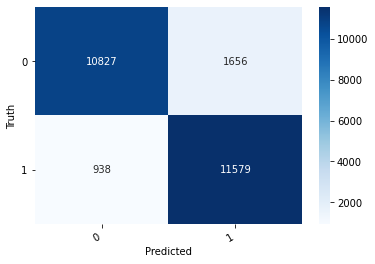

In [ ]:
cm = confusion_matrix(y_test, y_pred2)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

#Evaluating model's performance on the out-of-distribution set


In [ ]:
#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Truth')
  plt.xlabel('Predicted');


In [ ]:
def pred_class(text):
    #text = str(text).strip('"')
    X_sample = [text]
    X_sample = tokenizer.texts_to_sequences(X_sample)
    X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)

    y_sample = model_load.predict(X_sample).flatten()
    return y_sample


In [ ]:
#tokenizer = Tokenizer()

X_sample = ["This is nothing but a PC, insensitive insult to small-town churchgoers"]
print(X_sample)
X_sample = tokenizer.texts_to_sequences(X_sample)
X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)

y_sample = model_load.predict_classes(X_sample).flatten().tolist()
print(model_load.predict_proba(X_sample).flatten().tolist())
print('answer: 0',y_sample)

X_sample = ["Amazing movie, it is the best thing i watched this year"]
print(X_sample)
X_sample = tokenizer.texts_to_sequences(X_sample)
X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)
y_sample = model_load.predict(X_sample).flatten().tolist()
print(model_load.predict_proba(X_sample).flatten().tolist())
print('answer: 1',y_sample)

X_sample = ["Amazing movie, it is the best thing i watched this year"]
print(X_sample)
X_sample = tokenizer.texts_to_sequences(X_sample)
X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)
y_sample = model_load.predict(X_sample).flatten().tolist()
print(model_load.predict_proba(X_sample).flatten().tolist())
print('answer: 1',y_sample)


['This is nothing but a PC, insensitive insult to small-town churchgoers']
[2.577099849077058e-06]
answer: 0 [0]
['Amazing movie, it is the best thing i watched this year']
[0.9999825358390808]
answer: 1 [0.9999825358390808]
['Amazing movie, it is the best thing i watched this year']
[0.9999825358390808]
answer: 1 [0.9999825358390808]


In [ ]:
path = '/content/gdrive/My Drive/covid_mining/annotated_sentiment_manual_validation_set.csv' #this is from our manually annotated sentiment set
val_df = pd.read_csv(path,encoding='UTF-8')

In [ ]:
def label_text(text,model,tokenizer):
    X_sample = [text]
    X_sample = tokenizer.texts_to_sequences(X_sample)
    X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)

    pred = int(model.predict(X_sample).flatten()[0] > 0.5)
    
    return pred

def label_prob(text,model,tokenizer):
    X_sample = [text]
    X_sample = tokenizer.texts_to_sequences(X_sample)
    X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)

    pred = model.predict(X_sample).flatten()[0]
    return pred

In [ ]:
val_df = val_df[['title','vote_label']].dropna()
val_df.columns = ['X','y']
y_test = val_df.y.tolist()

In [ ]:
y_pred = [label_text(x,model_load,tokenizer) for x in val_df.X]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.39      0.48        56
         1.0       0.48      0.70      0.57        44

    accuracy                           0.53       100
   macro avg       0.55      0.55      0.53       100
weighted avg       0.56      0.53      0.52       100



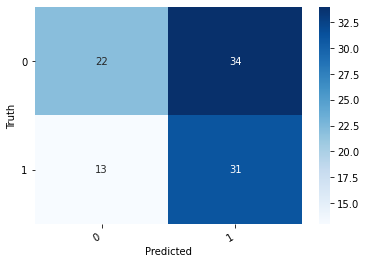

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

#labelling news data using CNN classifier



In [ ]:
import pandas as pd
#labelling news data
news_df = pd.read_csv('/content/gdrive/My Drive/covid_mining/covid19_articles_20200914.csv').drop(['Unnamed: 0'],axis=1)
news_df.head()

,title,url,crawled_time,date,domain,author,content,topic_area
0,Three Industrial Giants You Should Own In 2020,https://www.marketbeat.com/originals/three-ind...,2020-05-19,2020-01-02,marketbeat,Thomas Hughes,"Posted on Thursday, January 2nd, 2020 by Thoma...",business
1,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",https://www.marketbeat.com/originals/teal-brea...,2020-05-19,2020-01-03,marketbeat,Steve Anderson,"It could be forgiven, that some might think th...",business
2,Labor Stocks Are Going To Break Out In 2020,https://www.marketbeat.com/originals/labor-sto...,2020-05-19,2020-01-03,marketbeat,Thomas Hughes,"Posted on Friday, January 3rd, 2020 by Thomas ...",business
3,Cal-Maine Just Shed 12% - But Is Now The Time ...,https://www.marketbeat.com/originals/cal-maine...,2020-05-19,2020-01-06,marketbeat,Thomas Hughes,"Posted on Monday, January 6th, 2020 by Thomas ...",business
4,"China pneumonia outbreak: It's not SARS, so wh...",https://www.edition.cnn.com/2020/01/06/health/...,2020-06-22,2020-01-06,edition.cnn,"Nectar Gan, CNN",A total of 59 cases of unknown viral pneumonia...,business


In [ ]:
def label_text(text,model):
    X_sample = [text]
    X_sample = tokenizer.texts_to_sequences(X_sample)
    X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)

    pred = int(model.predict(X_sample).flatten()[0] > 0.5)
    
    return pred

def label_prob(text,model):
    X_sample = [text]
    X_sample = tokenizer.texts_to_sequences(X_sample)
    X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)

    pred = model.predict(X_sample).flatten()[0]
    return pred

In [ ]:
X_sample = news_df['title'].iloc[100]
print(X_sample)

X_sample = [X_sample]
X_sample = tokenizer.texts_to_sequences(X_sample)
X_sample = pad_sequences(X_sample, padding='post', maxlen=maxlen)
model_load.predict(X_sample)


CDC announces first US case of coronavirus that killed 17 in China


array([[0.38162827]], dtype=float32)

In [ ]:
news_df = news_df[['title','crawled_time','url','topic_area']]
news_df

,title,crawled_time,url,topic_area
0,Three Industrial Giants You Should Own In 2020,2020-05-19,https://www.marketbeat.com/originals/three-ind...,business
1,"Tesla (TSLA) Breaks Shipment Record, Beats Est...",2020-05-19,https://www.marketbeat.com/originals/teal-brea...,business
2,Labor Stocks Are Going To Break Out In 2020,2020-05-19,https://www.marketbeat.com/originals/labor-sto...,business
3,Cal-Maine Just Shed 12% - But Is Now The Time ...,2020-05-19,https://www.marketbeat.com/originals/cal-maine...,business
4,"China pneumonia outbreak: It's not SARS, so wh...",2020-06-22,https://www.edition.cnn.com/2020/01/06/health/...,business
...,...,...,...,...
290474,"Trump signs new, expanded executive order to l...",2020-09-14,https://finance.yahoo.com/news/trump-signs-exp...,business
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,https://finance.yahoo.com/news/nuggets-force-g...,business
290476,Health Official Out To Manipulate CDC Reports ...,2020-09-14,https://finance.yahoo.com/news/michael-caputo-...,business
290477,Global Markets: Asian shares buoyed by coronav...,2020-09-14,https://finance.yahoo.com/news/global-markets-...,business


In [ ]:
from tqdm import tqdm
tqdm.pandas()

news_df['predicted']  = news_df['title'].progress_apply(lambda x: label_text(x,model_load))


 25%|██▌       | 73820/290479 [1:44:44<5:02:41, 11.93it/s]

KeyboardInterrupt: ignored

In [ ]:
news_df['predict_prob']  = news_df['title'].progress_apply(lambda x: label_prob(x,model_load))

KeyboardInterrupt: ignored

In [ ]:
news_df[['title','predicted','predict_prob','url']]

KeyError: ignored